<a href="https://colab.research.google.com/github/geomars/challenges/blob/main/Part2_Labs247Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interview Lab: Forecasting Analysis of Time Series Data

## Author

Georgia Martha Sari

In [1]:
__author__ = 'egogeomars'

## Libraries Import

In [2]:
import os

import datetime as dt
import numpy as np
import pandas as pd
pd.options.display.max_columns = 50

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import seaborn as sns
sns.set(color_codes=True)
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Data Overview

The dataset is economic data for Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2) (IPG2211A2N) which can be downloaded from https://fred.stlouisfed.org/series/IPG2211A2N. The shorter version of the dataset used in this lab was obtained from [here](https://www.kaggle.com/shenba/time-series-datasets#Electric_Production.csv)

### Data Import and Initial Exploration

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
fullpath = '/content/drive/My Drive/datasets/Electric_Production.csv' 

Mounted at /content/drive


In [4]:
df = pd.read_csv(fullpath, sep=',', index_col=0, parse_dates=True, encoding='ascii')
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
df = df.rename(columns={'IPG2211A2N':'Usage'})
df.index.names = ['Date']

In [6]:
df.head()

,Usage
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [7]:
df.tail()

,Usage
Date,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


Check missing data

In [8]:
df.isna().sum()

Usage    0
dtype: int64

Display summary statistics

In [9]:
df.describe()

,Usage
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


## Resampling

Find out **average** and **median** usage in each quarterly frequence

In [10]:
quarterly_average_usage = df.resample('Q').mean() # 
quarterly_average_usage.head(10)

,Usage
Date,
1985-03-31,68.542467
1985-06-30,56.958967
1985-09-30,62.151100
1985-12-31,61.010133
1986-03-31,67.838233
1986-06-30,57.582367
1986-09-30,63.749200
1986-12-31,61.669767
1987-03-31,69.829067


In [11]:
#
quarterly_median_usage = df.resample('Q').mean() 
# 
quarterly_median_usage.head(10)

,Usage
Date,
1985-03-31,68.542467
1985-06-30,56.958967
1985-09-30,62.151100
1985-12-31,61.010133
1986-03-31,67.838233
1986-06-30,57.582367
1986-09-30,63.749200
1986-12-31,61.669767
1987-03-31,69.829067


## Visualize the time series data

Let's make a plot of the electrical usage trend

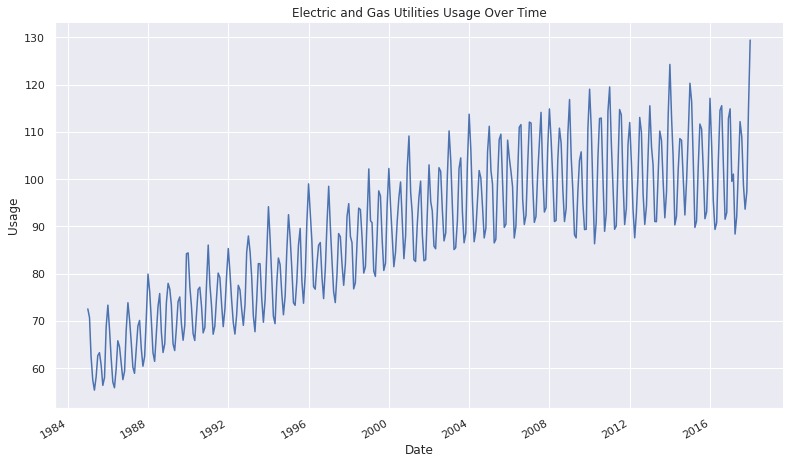

In [12]:
g = sns.relplot(x="Date", y="Usage", kind="line", data=df)
g.fig.set_figwidth(12)
g.fig.set_figheight(7)
g.fig.autofmt_xdate()
plt.title("Electric and Gas Utilities Usage Over Time")
plt.show(g)

As we visualize the Electric and Gas Utilities Usage data we can see there is both an upward trend and an increasing variance in the data and there is **seasonality** to it.

## Stationary Test

Test for stationarity with the **Augmented Dickey-Fuller** test.

In this case, the `adfuller` library is imported from the `statsmodels` library and then run the data through the test.

In [13]:
from statsmodels.tsa.stattools import adfuller

adf_results = {}

for col in df["Usage"].values:  
    adf_results[col] = adfuller(df["Usage"])

Let’s look specifically at ADF and p-values.

In [14]:
print( "ADF = " + str(list(adf_results.values())[0][0]) )
print( "p-value = " + str(list(adf_results.values())[0][1]) )

ADF = -2.256990350047245
p-value = 0.1862146911658677


Our `p-value` 0.186 is near-marginal significance. It indicates weak evidence against the null hypothesis, we fail to reject the null hypothesis. In other words, we can assume our data is **non-stationary**.

## Estimate the model parameter using Auto ARIMA

Let's run `auto_arima()` function to get best (p,d,q) and (P,D,Q) values

In [15]:
!pip install pmdarima

In [16]:
from pmdarima.arima import auto_arima

stepwise_fit = auto_arima(df['Usage'], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True,  
                             stepwise=True) 

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1785.652, Time=1.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2010.162, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1940.101, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1835.298, Time=0.55 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1787.226, Time=1.26 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1786.885, Time=4.39 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1872.182, Time=0.84 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1785.329, Time=4.09 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=1770.670, Time=4.50 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=1773.643, Time=2.97 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1814.635, Time=4.30 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=1835.292, Time=3.79 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=1772.091, Time=8.00 sec
 ARIMA(1,1,2)(2,1,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  397
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -877.110
Date:                                 Wed, 17 Feb 2021   AIC                           1770.221
Time:                                         09:26:02   BIC                           1801.826
Sample:                                              0   HQIC                          1782.757
                                                 - 397                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0027      0.001     -3.001      0.003      -0.004      -0.001
ar.L1          0.5223      0.043     12.078      0.000       0.438       0.607
ma.L1         -0.9799      0.012    -80.768      0.000      -1.004      -0.956
ar.S.L12       0.3758      0.181      2.079      0.038       0.022       0.730
ar.S.L24      -0.3018      0.058     -5.197      0.000      -0.416      -0.188
ma.S.L12      -1.1071      0.183     -6.063      0.000      -1.465      -0.749
ma.S.L24       0.3733      0.148      2.523      0.012       0.083       0.663
sigma2         5.3928      0.322     16.731      0.000       4.761       6.025
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                21.59
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               2.84   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto ARIMA suggests that SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12) with AIC value of AIC=1770.221 is the best combination, so we should consider this to be optimal option.

In [17]:
t1 = df['1985-01-01':'2011-04-01']
t2 = df['2011-05-01':'2018-01-01']

## Fit the parameter to the model

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

arima_model = SARIMAX(t1.Usage, order=(1, 1, 1), seasonal_order=(2, 1, 2, 12))
arima_result = arima_model.fit(disp=False)
print(arima_result.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                        SARIMAX Results                                        
Dep. Variable:                                   Usage   No. Observations:                  316
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -667.467
Date:                                 Wed, 17 Feb 2021   AIC                           1348.934
Time:                                         09:26:10   BIC                           1374.930
Sample:                                     01-01-1985   HQIC                          1359.335
                                          - 04-01-2011                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5028      0.058      8.733      0.000       0.390       0

## Predictions of ARIMA Model

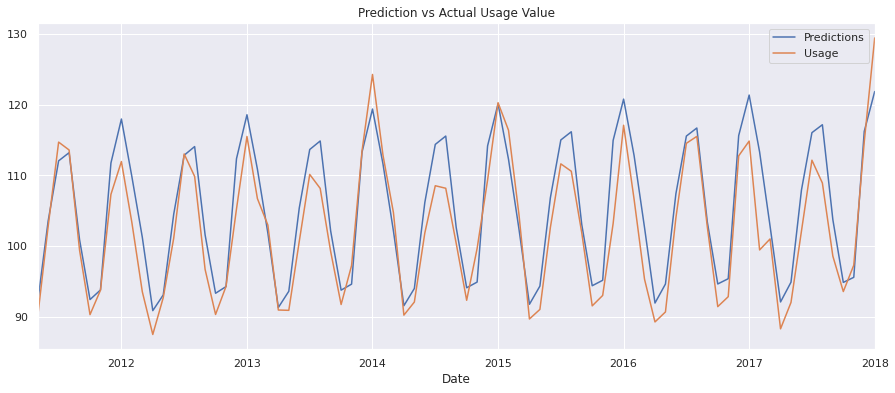

In [19]:
start = len(t1) 
end = len(t1) + len(t2) - 1
predictions = arima_result.predict(start, end, typ = 'levels').rename("Predictions") 
predictions.plot(legend = True) 
t2.Usage.plot(legend = True) 
plt.title('Prediction vs Actual Usage Value')
plt.show()

## Evaluate the model using MSE and RMSE

In [20]:
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 

print( 'SARIMA model RMSE:{}'.format(rmse(t2.Usage, predictions)) )
print( 'SARIMA model MSE:{}'.format(mean_squared_error(t2.Usage, predictions)) )

SARIMA model RMSE:4.3190760369838275
SARIMA model MSE:18.65441781324792


## Forecasting using ARIMA Model

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


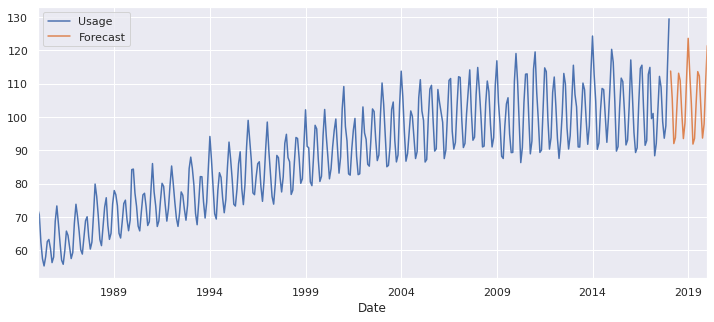

In [21]:
model = SARIMAX(df['Usage'], order = (1, 1, 1), seasonal_order =(2, 1, 2, 12)) 
result = model.fit() 

forecast = result.predict(start = len(df), 
						end = (len(df)-1) + 2 * 12, 
						typ = 'levels').rename('Forecast') 

df['Usage'].plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True)
plt.show()

## Usage Forecasting for The Next 6 Months

In [26]:
future = pd.DataFrame(forecast)
future[:6]

,Forecast
2018-02-01,113.751160
2018-03-01,105.535163
2018-04-01,92.007786
2018-05-01,93.792505
2018-06-01,103.695164
2018-07-01,113.097079
